# Check accuracy of candlestick patterns on FOREX dataset

#### The problem:

Check if it is possible to predict forex price movements only based on candlestick data.
We will use 1h time-frame data set of EUR/USD during ~2014-2019 year.
We will take only 3 last candles and based on that make a prediction of the next candle.

#### The example of candlestick patterns that we will try to predict or prove that those kind of patterns exists and work:

![Candlestick popular patterns](popular_candlestick_patterns.png)

#### Before we even start, we need to download all the required libraries to perform the task.

In [122]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap

#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
#import numpy as np
#import urllib
#import datetime as dt

print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


## Get the dataset.

We will download our historical dataset from ducascopy website in form of CSV file.
https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed

In [279]:
my_dataset = pd.read_csv('EURUSD_1H_2014_2019.csv')

#### Check the imported data

In [280]:
del my_dataset['Gmt time']
del my_dataset['Volume']

In [281]:
my_dataset.head(5)

,Open,High,Low,Close
0,1.31950,1.31956,1.31942,1.31954
1,1.31954,1.31954,1.31954,1.31954
2,1.31954,1.31954,1.31954,1.31954
3,1.31954,1.31954,1.31954,1.31954
4,1.31954,1.31954,1.31954,1.31954


### Let's visualize it on the actual OHLC candlestick chart.

In order to do that we need to make our own function that will plot the OHLC data on the chart.
We will use matplotlib library with finnance extension called mpl_finance.
But before that, we need prepare out dataset to be in 3 dimensional arre with format (Timestep, Items, Features)

Timestep = List of candles seqeuence

Items = Candlestick

Features = High, Low, Open, Close parametes

### Function to plot OHLC candlestick data in to chart

In [299]:
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))
    
    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')
    
    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

#### Visualize 1000 candlesticks on the OHLC chart in one time

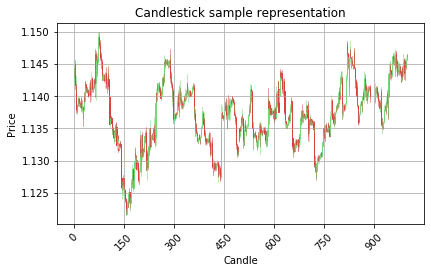

In [300]:
graph_data_ohlc(my_dataset.tail(1000).values)

### Change the format of our dataset to 3 dimensional array (Timestep, Items, Features) 

#### Custom generator function to create 3d arrays of candles sequence

In [301]:
def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):       
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            temp_list.append(candle)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [303]:
three_dim_sequence = np.asarray(my_generator(my_dataset.values[1:],3))

Let's check the shape of our 3 dimension array, we got:
37557 sequences of 3 candles,
each candle has 4 parameters.

In [304]:
three_dim_sequence.shape

(37557, 3, 4)

### OK, now it is time to see how our sequence of 3 candlesticks looks like on the actual chart

Visualize the step by step sequency of price movements on the OHLC chart

Step 1


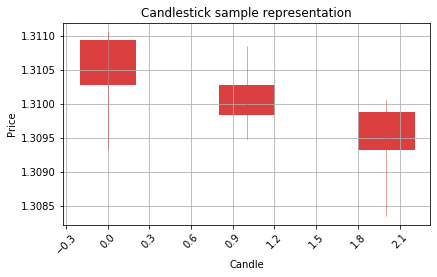

Step 2


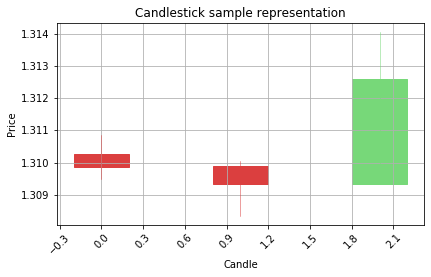

Step 3


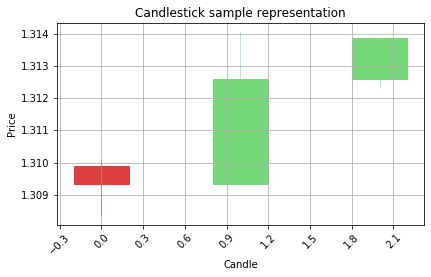

Step 4


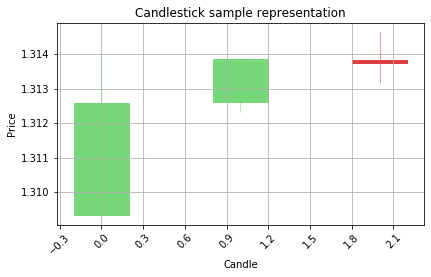

Step 5


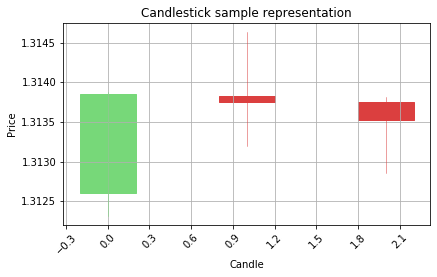

Step 6


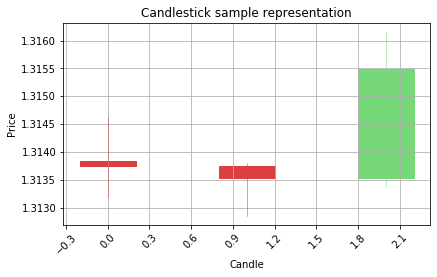

Step 7


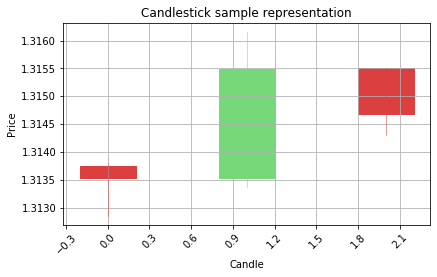

Step 8


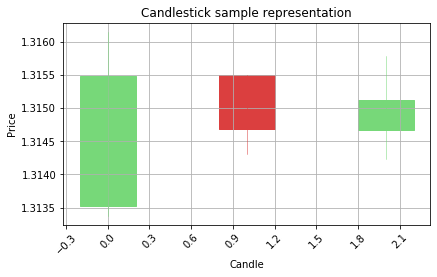

Step 9


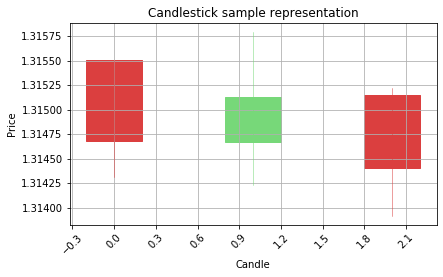

Step 10


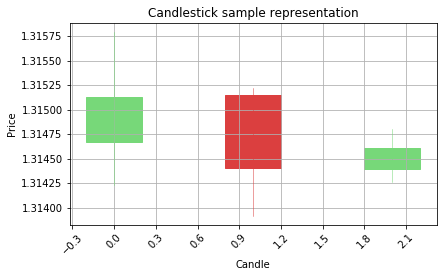

In [305]:
counter=0
for candle in three_dim_sequence[1000:1010]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)

##  Now it is time to convert the price data in to actual candlestick parameters. Each candle has 4 parameters:

1. Size of the body measured by pips  
2. Size of the upper wicks measured by pips
3. Size of the lower wicks measured by pips
4. Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)

pip = diffrence between 2 prices multiplied by 10000

(The whole process of enriching the raw dataset is called 'feature engineering')

### Function to convert OHLC data in to candlestick parameters data

In [306]:
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]
    
    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]
        
    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]

    
    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)
    
    return candlestick_data

Lets extract data of only one candle from our dataset of sequences

In [307]:
one_candle_data_ohlc=three_dim_sequence[1000:1010][5][1]

In [308]:
one_candle_data_ohlc

array([1.31375, 1.31381, 1.31286, 1.31353])

Convert it to candlestick parameters

In [309]:
one_candle_data_ohlc_candle=ohlc_to_candlestick(one_candle_data_ohlc)

In [310]:
one_candle_data_ohlc_candle

[0, 0.6, 6.7, 2.8]

### Apply this function in to generator function to get sequences with candlestick data instead of OHLC data

In [311]:
def my_generator_candle(data,lookback):
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [312]:
three_dim_sequence_candle=my_generator_candle(my_dataset.values[1:],3)

Check if conversion applied correctly

In [313]:
three_dim_sequence_candle[5000:5005]

array([[[ 0. ,  3.2,  8.6, 10. ],
        [ 1. ,  2.2,  8.2, 11. ],
        [ 0. ,  2.5,  9.1,  2.7]],

       [[ 1. ,  2.2,  8.2, 11. ],
        [ 0. ,  2.5,  9.1,  2.7],
        [ 1. ,  6.2,  3.2,  5.3]],

       [[ 0. ,  2.5,  9.1,  2.7],
        [ 1. ,  6.2,  3.2,  5.3],
        [ 0. ,  0.6,  5.4, 16.2]],

       [[ 1. ,  6.2,  3.2,  5.3],
        [ 0. ,  0.6,  5.4, 16.2],
        [ 0. ,  3.4,  6. ,  7.4]],

       [[ 0. ,  0.6,  5.4, 16.2],
        [ 0. ,  3.4,  6. ,  7.4],
        [ 1. ,  4.8,  8.8,  0.1]]])

## Generate forecasting data

Now we have our candlestick values in the correct format for machine to read it and interpret it so, it is time
to generete our prediction/forecasting data.

The idea was to predict the next candle type (bullish or bearish) by looking on for the last 3 candles.
We got our sequences of 3 candles and now we need to generate another array with one candle information,
which we will be forecasting.

#### Update of the generator to return one more array with 1 or 0 (Bullish or Bearish)

In [314]:
def my_generator_candle_X_Y(data,lookback,MinMax = False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,4))
    Y_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)
        
        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:    
            arr = np.append(arr, templist4, axis=0)
        
        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        Y_list.append(Prediction)

        first_row=first_row+1

    arr2 = np.asarray(Y_list)
    
    return arr,arr2,arr3

#### We will call the function and receive 2 datasets:

X = Input dataset on which our neural network will make predictions

Y = Prediction dataset (results of the correct predictions)

In [315]:
X,Y, X_raw = my_generator_candle_X_Y(my_dataset.values,3,MinMax=False)

Exploring the genereted dataset:

In [316]:
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

Shape of X (37557, 3, 4)
Shape of Y (37557,)
Shape of X raw ohlc (37557, 3, 4)


In [317]:
X[653]

array([[ 1. ,  4.5,  0.3, 15.8],
       [ 1. ,  2.6,  1. ,  9. ],
       [ 0. ,  6.3,  7.2, 13.8]])

In [319]:
Y[653]

1

In [321]:
X_raw[653]

array([[1.35109, 1.35312, 1.35106, 1.35267],
       [1.35267, 1.35383, 1.35257, 1.35357],
       [1.3536 , 1.35423, 1.35213, 1.35285]])

#### Visualize the candle sequence:

Prediction is Bearsih


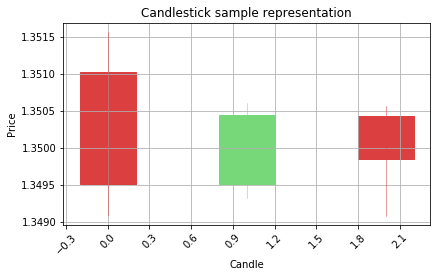

Prediction is Bearsih


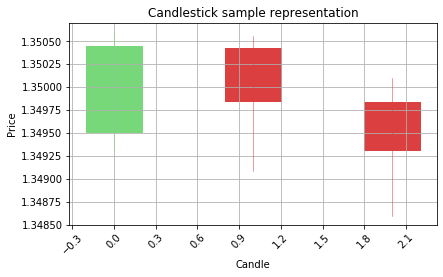

Prediction is Bearsih


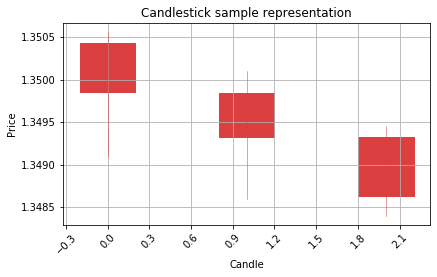

Prediction is Bearsih


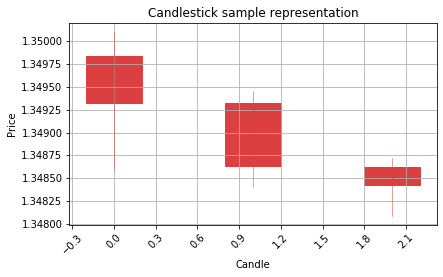

Prediction is Bullish


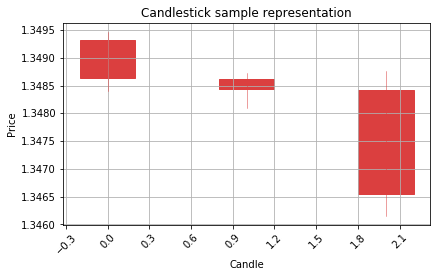

Prediction is Bullish


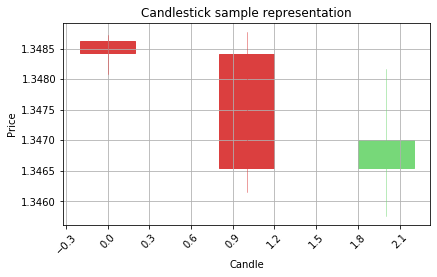

Prediction is Bearsih


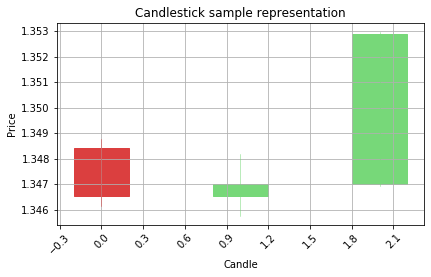

Prediction is Bullish


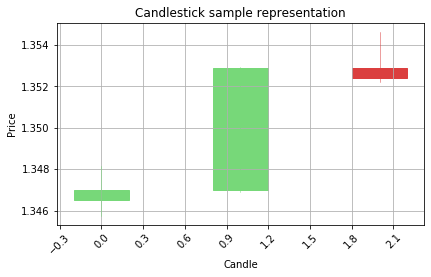

Prediction is Bullish


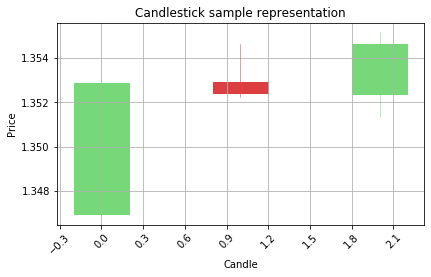

Prediction is Bearsih


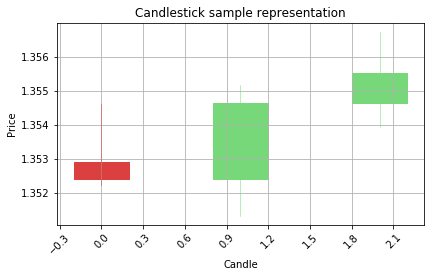

In [322]:
for a in range(10):
    b=a+600
    if Y[b] == 1:print('Prediction is Bullish')
    if Y[b] == 0:print('Prediction is Bearsih')
    graph_data_ohlc(X_raw[b])

# Build Deep Neural Network model

#### For all sequence dataset the best model are RNN - Recurrent neural network. For our case we will build the LSTM network ( Long-Term Short-Term) 

The basics, for all the training and prediction will be responsible the tensorflow library, with high level API called KERAS.

## Defining the model

In [351]:
from keras import layers
from keras.optimizers import RMSprop

#3 * 4 = 12
#15 * 4 = 60

model = Sequential()

model.add(layers.CuDNNLSTM(units = 120,return_sequences=True, input_shape = (None, X.shape[-1])))

model.add(layers.CuDNNLSTM(units = 240))


model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


#### Definition of the compiled model

In [352]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_52 (CuDNNLSTM)    (None, None, 120)         60480     
_________________________________________________________________
cu_dnnlstm_53 (CuDNNLSTM)    (None, 240)               347520    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 241       
Total params: 408,241
Trainable params: 408,241
Non-trainable params: 0
_________________________________________________________________


### In order train the deep learning model we need to split our data for 3 parts:
1. Traning dataset
2. Validation dataset
3. Test dataset

In [353]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw, X_val_and_test_raw= train_test_split(X_raw, test_size=0.5)
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5)

In [354]:
print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_val.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_test.shape))

Training data: X Input shape: (18778, 3, 4), Y Output shape: (18778,), datetime shape: (18778,)
Validation data: X Input shape: (9389, 3, 4), Y Output shape: (9389,), datetime shape: (9389,)
Test data: X Input shape: (9390, 3, 4), Y Output shape: (9390,), datetime shape: (9390,)


### Train the Neural Network model and save trainig outputs 'history' variable

In [355]:
history = model.fit(X_train, Y_train,batch_size=500, epochs=15,validation_data=(X_val, Y_val))

Train on 18778 samples, validate on 9389 samples
Epoch 1/15
18778/18778 [==============================] - 5s 266us/step - loss: 0.6983 - acc: 0.4984 - val_loss: 0.6954 - val_acc: 0.5054
Epoch 2/15
18778/18778 [==============================] - 2s 84us/step - loss: 0.6934 - acc: 0.5092 - val_loss: 0.6927 - val_acc: 0.5152
Epoch 3/15
18778/18778 [==============================] - 1s 79us/step - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6927 - val_acc: 0.5122
Epoch 4/15
18778/18778 [==============================] - 2s 81us/step - loss: 0.6927 - acc: 0.5149 - val_loss: 0.6936 - val_acc: 0.5028
Epoch 5/15
18778/18778 [==============================] - 2s 91us/step - loss: 0.6920 - acc: 0.5228 - val_loss: 0.6936 - val_acc: 0.5109
Epoch 6/15
18778/18778 [==============================] - 2s 84us/step - loss: 0.6917 - acc: 0.5227 - val_loss: 0.6922 - val_acc: 0.5194
Epoch 7/15
18778/18778 [==============================] - 2s 84us/step - loss: 0.6911 - acc: 0.5264 - val_loss: 0.6916 - val_acc

### Plot the charts to see model training loss and validation loss

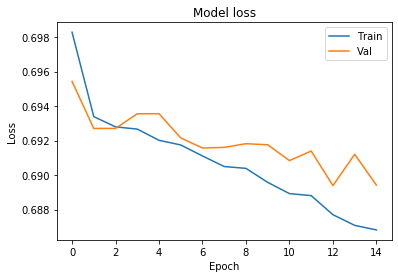

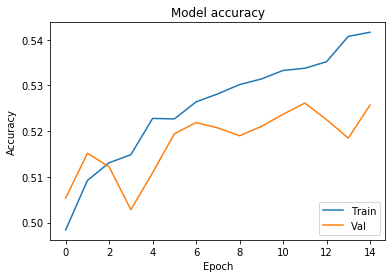

In [356]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


### Test the model against new data

In [357]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

9390/9390 [==============================] - 2s 242us/step
Test accuracy: 0.5355697550649207


### Visualize the predictions on the candlestick charts to see the patterns

Belowe there is a function to filter out the low confidence predictions from the model by using the alpha distance variable. If the prediction value is close to 0, that means the prediction is 0, the same case wth prediction 1, if the predicted value is closer to 1 instead of 0, it means the model predicted the value 1. If the prediction value is closer to its target, that means the confidence of the prediction is biger. Less distance to target prediction value, better the confidence. Please make sure that this approach works only with binary classification problems.

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


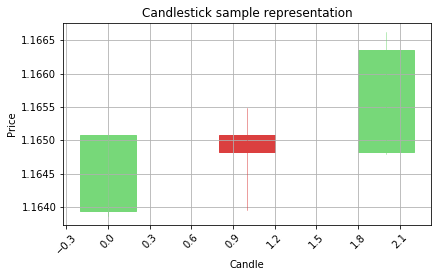

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


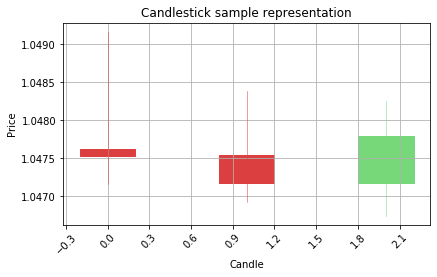

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


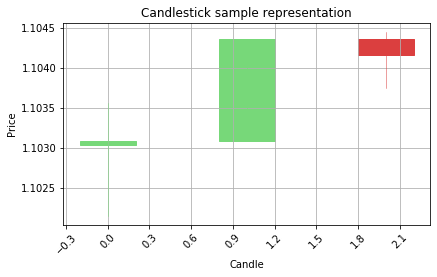

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


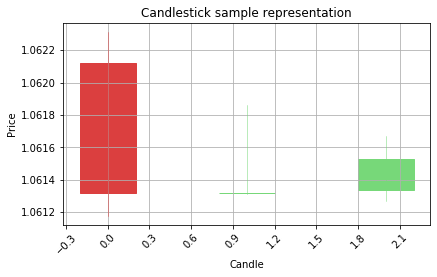

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


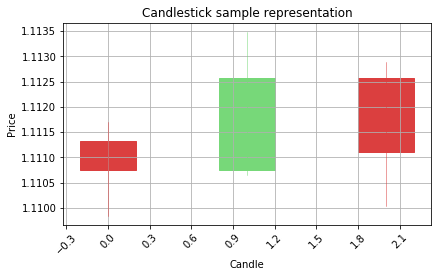

[0.34993026]
Correct prediction is Bullish
Model prediction is Bearish
LOST


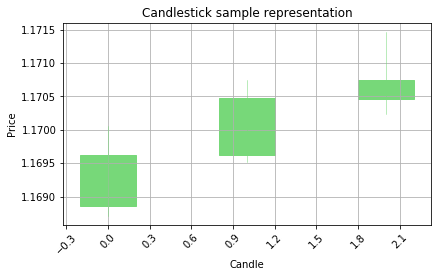

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


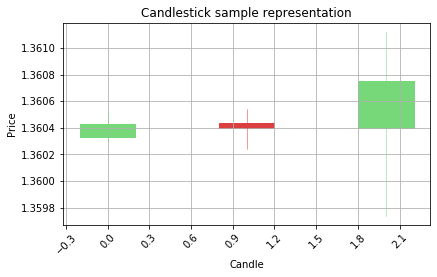

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


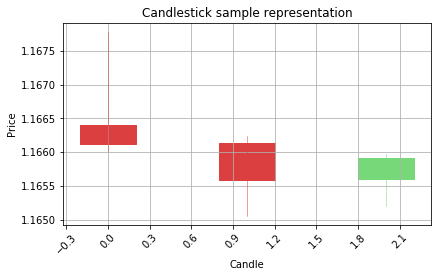

[0.67938906]
Correct prediction is Bullish
Model prediction is Bullish
WON


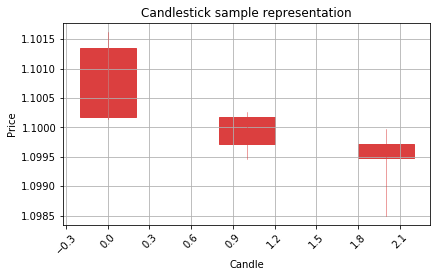

[0.32397097]
Correct prediction is Bearish
Model prediction is Bearish
WON


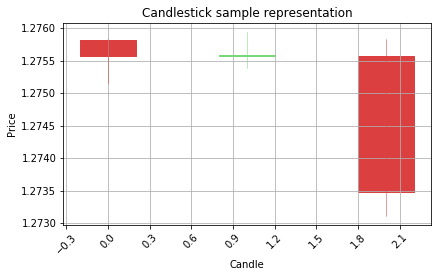

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


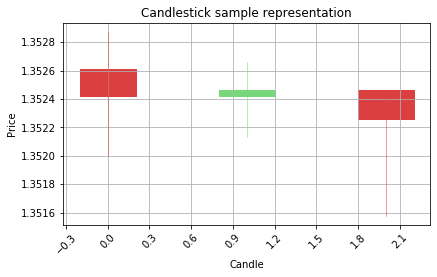

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


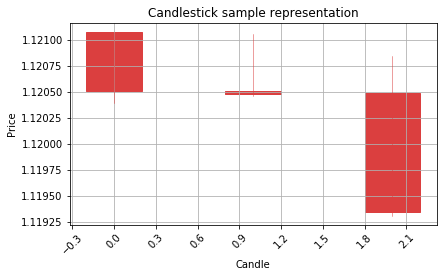

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


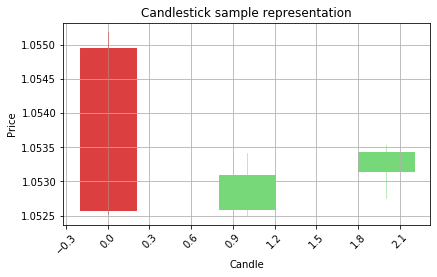

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


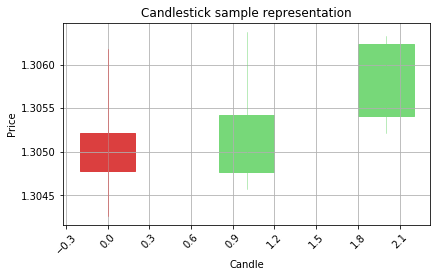

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


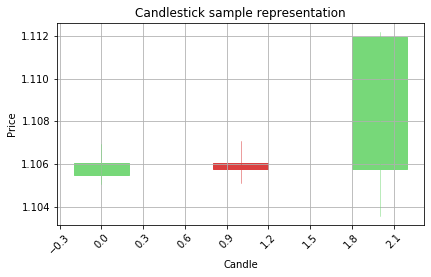

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


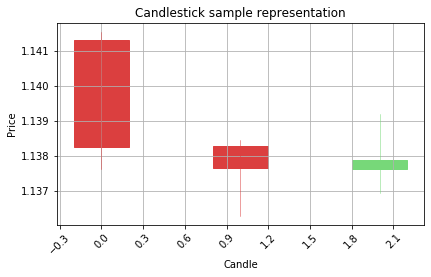

[0.32663727]
Correct prediction is Bullish
Model prediction is Bearish
LOST


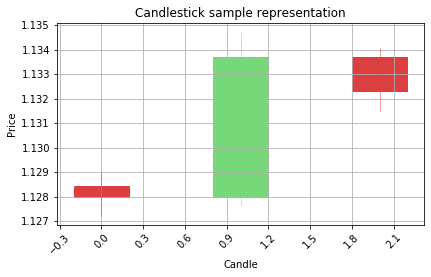

[0.10849303]
Correct prediction is Bullish
Model prediction is Bearish
LOST


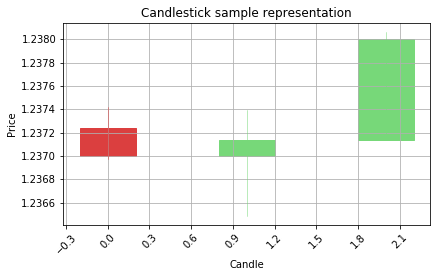

[0.6578362]
Correct prediction is Bearish
Model prediction is Bullish
LOST


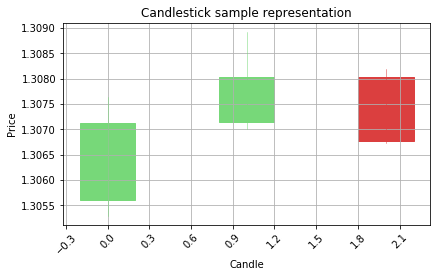

[0.68862885]
Correct prediction is Bearish
Model prediction is Bullish
LOST


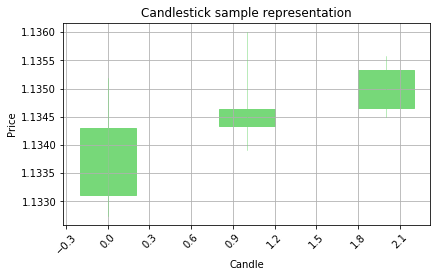

[0.67466366]
Correct prediction is Bullish
Model prediction is Bullish
WON


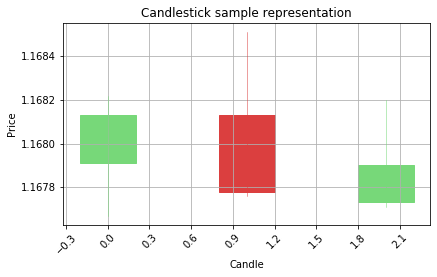

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


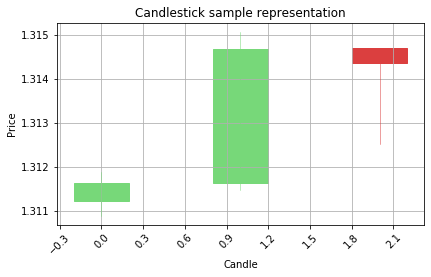

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


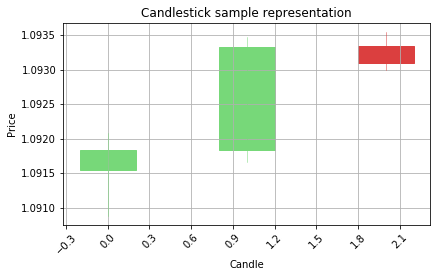

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


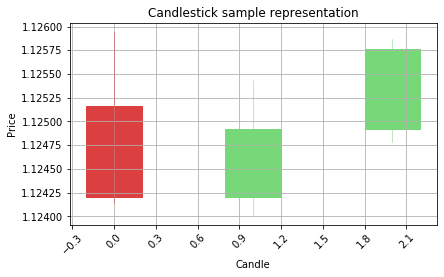

[0.16982178]
Correct prediction is Bearish
Model prediction is Bearish
WON


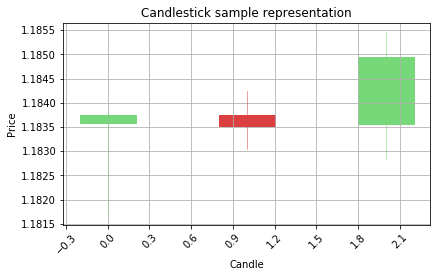

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


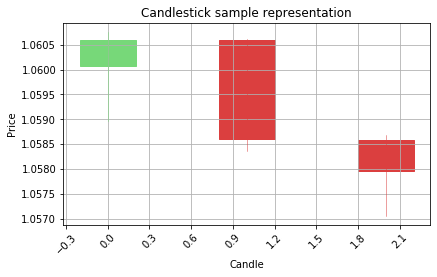

[0.2952553]
Correct prediction is Bearish
Model prediction is Bearish
WON


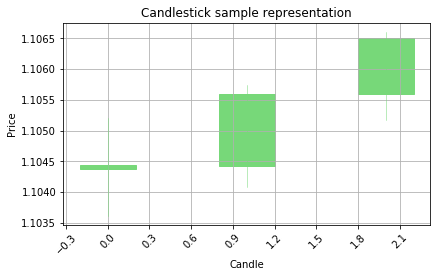

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


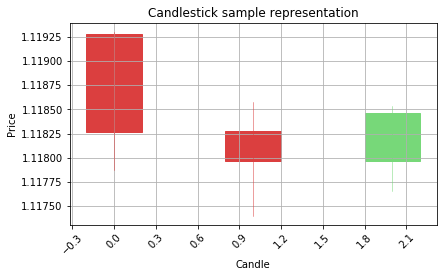

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


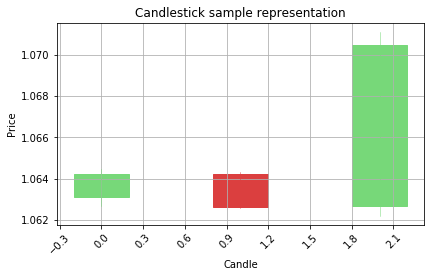

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


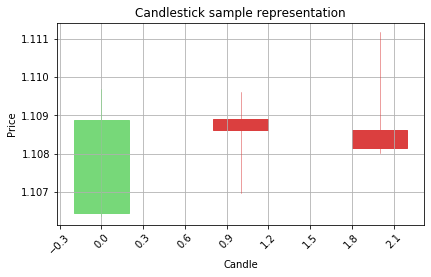

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


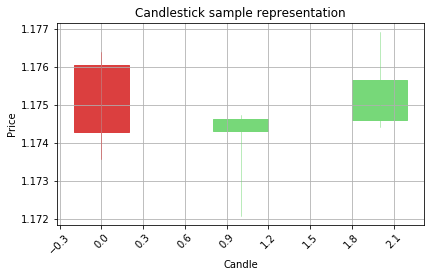

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


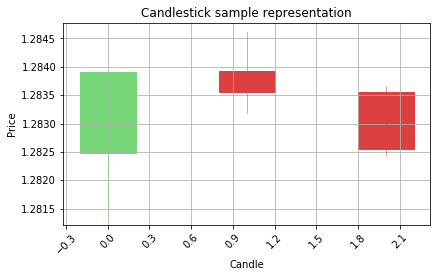

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


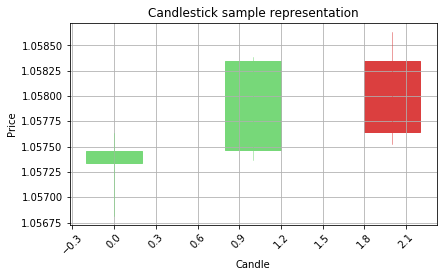

[0.34855026]
Correct prediction is Bearish
Model prediction is Bearish
WON


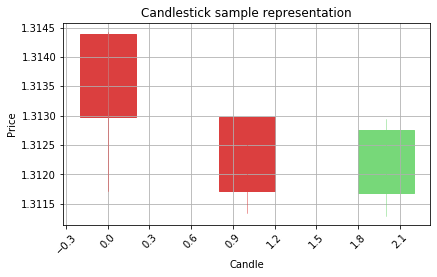

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


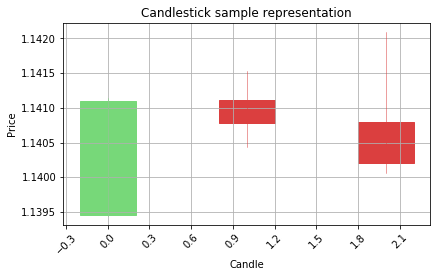

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


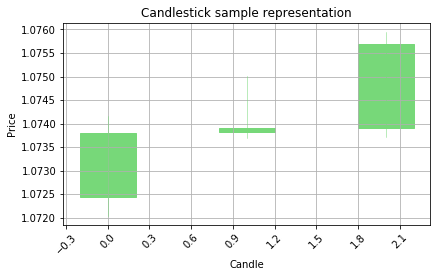

[0.6835045]
Correct prediction is Bearish
Model prediction is Bullish
LOST


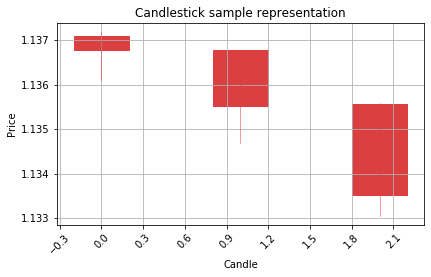

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


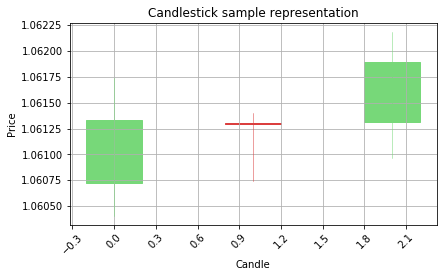

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


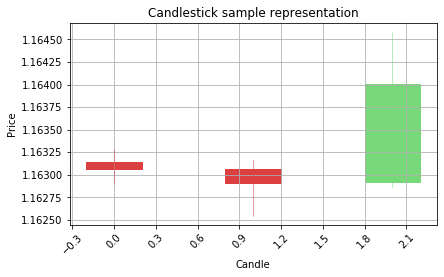

[0.3492678]
Correct prediction is Bearish
Model prediction is Bearish
WON


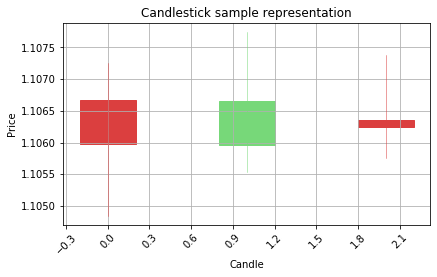

[0.33848575]
Correct prediction is Bearish
Model prediction is Bearish
WON


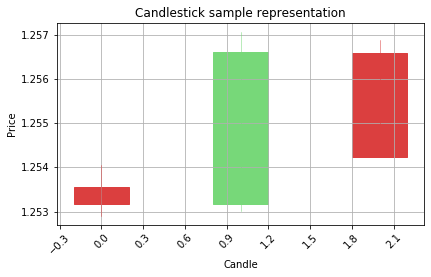

[0.29145387]
Correct prediction is Bullish
Model prediction is Bearish
LOST


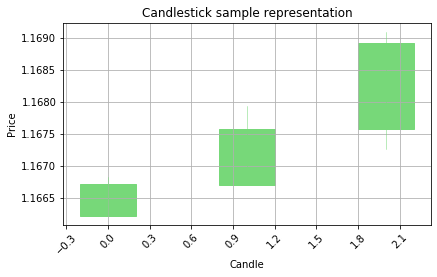

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


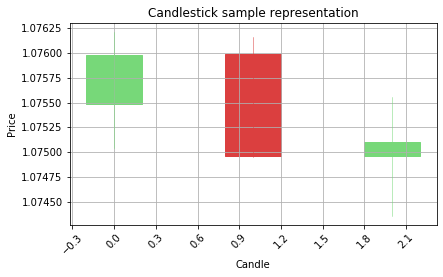

[0.65764815]
Correct prediction is Bearish
Model prediction is Bullish
LOST


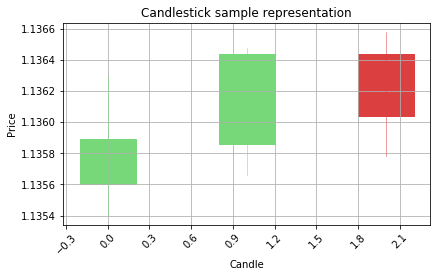

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


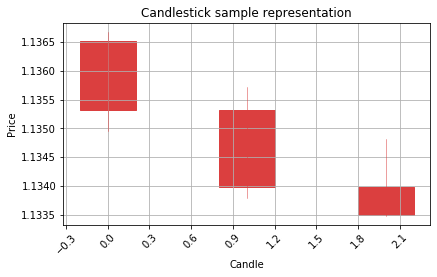

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


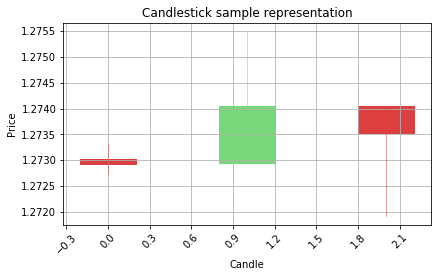

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


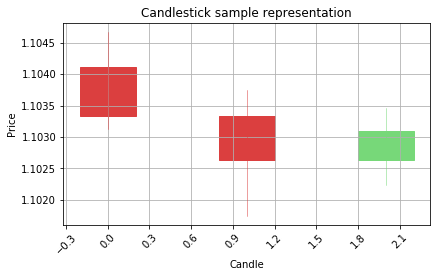

[0.6653333]
Correct prediction is Bullish
Model prediction is Bullish
WON


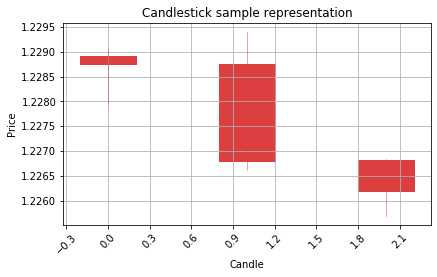

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


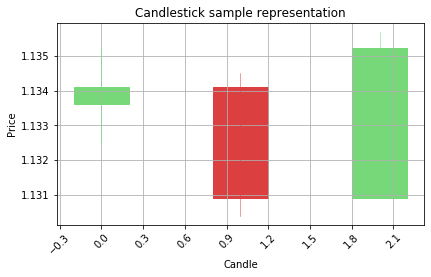

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


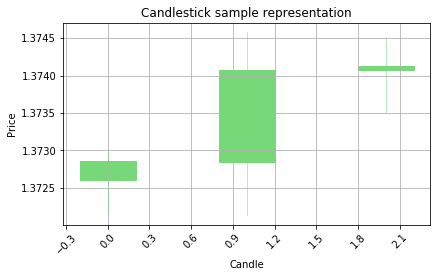

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


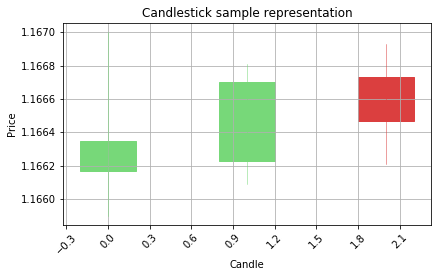

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


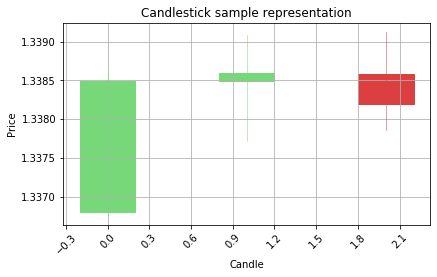

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


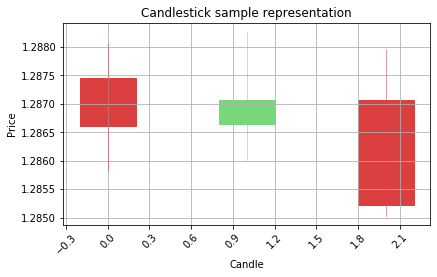

[0.3400402]
Correct prediction is Bearish
Model prediction is Bearish
WON


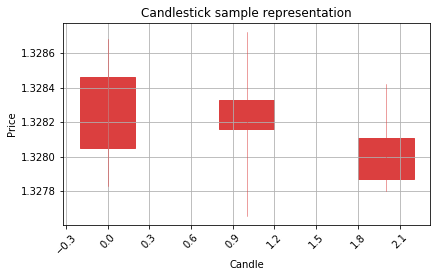

[0.34754652]
Correct prediction is Bullish
Model prediction is Bearish
LOST


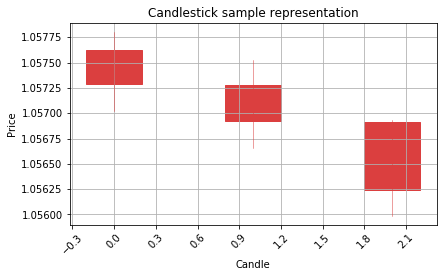

[0.3401089]
Correct prediction is Bearish
Model prediction is Bearish
WON


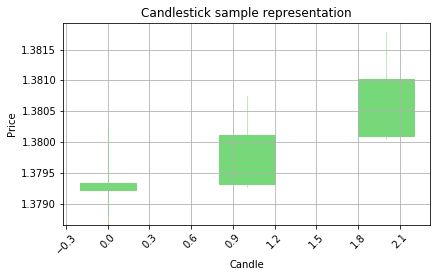

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


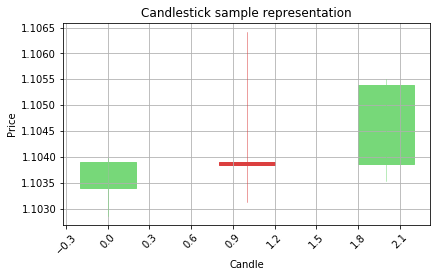

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


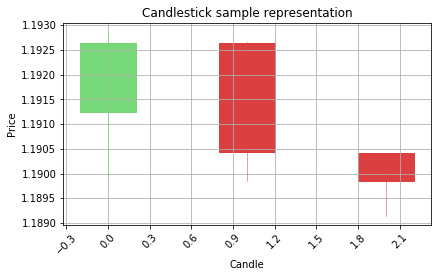

[0.6791436]
Correct prediction is Bearish
Model prediction is Bullish
LOST


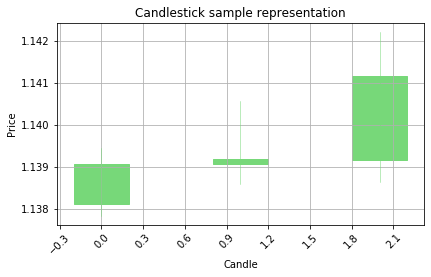

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


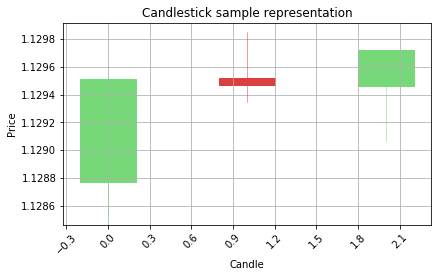

[0.33877176]
Correct prediction is Bearish
Model prediction is Bearish
WON


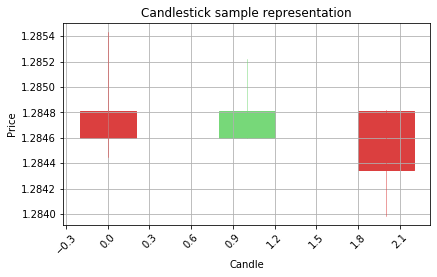

[0.10849303]
Correct prediction is Bearish
Model prediction is Bearish
WON


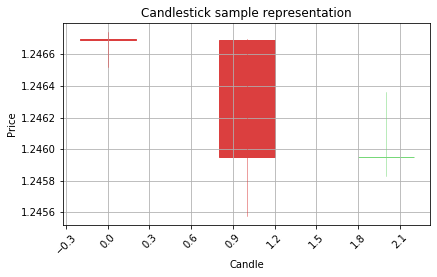

[0.32781577]
Correct prediction is Bullish
Model prediction is Bearish
LOST


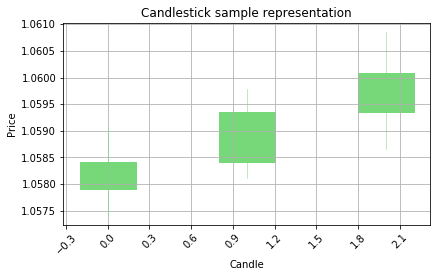

Won: 52 Lost: 11
Success rate: 82.54%


In [372]:
counter = 0
won = 0
lost = 0
test = model.predict(X_test)
alpha_distance = 0.35

for a in test:
    #print(a)
    if a > (1-alpha_distance) or a < alpha_distance :
        print(a)
        if Y_test[counter] == 1:print('Correct prediction is Bullish')
        if Y_test[counter] == 0:print('Correct prediction is Bearish')
        if a > (1-alpha_distance):print('Model prediction is Bullish')
        if a < alpha_distance:print('Model prediction is Bearish')
        
        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        graph_data_ohlc(X_test_raw[counter])
        
    counter=counter+1
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')


### Looks like we manage the get awesome results with our model after manipulating the alpha_distance value.
# Won: 52 Lost: 11
# Success rate: 82.54%
# Test period: 13 Months
### Thats huge!
### But the game is not over, when we have our model achieving awesome results on the test data, it is time to move in to data out of the sample (data that is not related to the previous data and the deep learning model never had contact with this kind of data) or to the live data. We will try both of those approaches.

### Before will will start making out of the sample test, let's check which features were the most important for the model to make predictions.


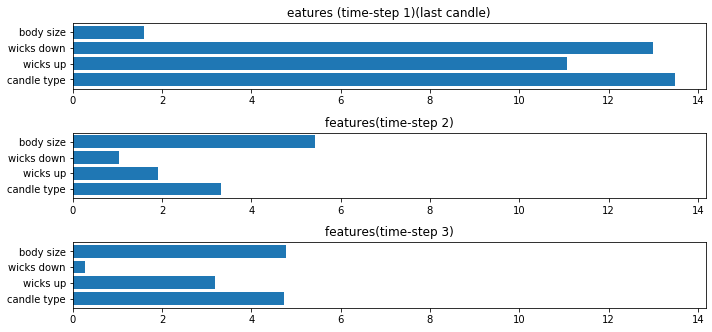

In [373]:
pred_x = model.predict(X_train)

random_ind = np.random.choice(X_train.shape[0], 1000, replace=False)

data = X_train[random_ind[0:500]]
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output),data)
test1 = X_train[random_ind[500:1000]]
shap_val = e.shap_values(test1)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)
f_names = ['candle type','wicks up', 'wicks down', 'body size']
x_pos = [i for i, _ in enumerate(f_names)]

plt.figure(figsize=(10,6))

plt1 = plt.subplot(4,1,1)
plt1.barh(x_pos,sum_0[2])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title('eatures (time-step 1)(last candle)')

plt2 = plt.subplot(4,1,2,sharex=plt1)
plt2.barh(x_pos,sum_0[1])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title('features(time-step 2)')

plt3 = plt.subplot(4,1,3,sharex=plt1)
plt3.barh(x_pos,sum_0[0])
plt3.set_yticks(x_pos)
plt3.set_yticklabels(f_names)
plt3.set_title('features(time-step 3)')

plt.tight_layout()
plt.show()

# Now it is time to download the big dataset of more than 
# 0.7 Milion of historical 1 hour candlestciks from 7 currency pairs

We will download our historical dataset from ducascopy website in form of many CSV files.
https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed

    *EURUSD
    *GBPUSD
    *USDCAD
    *NZDUSD
    *USDJPY
    *AUDUSD
    *USDCHF
All of the above datasets are for time period od 2003-2019

#### EURUSD

In [376]:
EURUSD_dataset = pd.read_csv('Hour/EURUSD.csv')
del EURUSD_dataset['Gmt time']
del EURUSD_dataset['Volume']
X,Y, X_raw = my_generator_candle_X_Y(EURUSD_dataset.values,3,MinMax=False)

#### GBPUSD

In [381]:
GBPUSD_dataset = pd.read_csv('Hour/GBPUSD.csv')
del GBPUSD_dataset['Gmt time']
del GBPUSD_dataset['Volume']
X2,Y2, X2_raw = my_generator_candle_X_Y(GBPUSD_dataset.values,3,MinMax=False)

#### USDCAD

In [383]:
USDCAD_dataset = pd.read_csv('Hour/USDCAD.csv')
del USDCAD_dataset['Gmt time']
del USDCAD_dataset['Volume']
X3,Y3, X3_raw = my_generator_candle_X_Y(USDCAD_dataset.values,3,MinMax=False)

#### NZDUSD

In [385]:
NZDUSD_dataset = pd.read_csv('Hour/NZDUSD.csv')
del NZDUSD_dataset['Gmt time']
del NZDUSD_dataset['Volume']
X4,Y4, X4_raw = my_generator_candle_X_Y(NZDUSD_dataset.values,3,MinMax=False)

#### USDJPY

In [389]:
USDJPY_dataset = pd.read_csv('Hour/USDJPY.csv')
del USDJPY_dataset['Gmt time']
del USDJPY_dataset['Volume']
X5,Y5, X5_raw = my_generator_candle_X_Y(USDJPY_dataset.values,3,MinMax=False)

#### AUDUSD

In [391]:
AUDUSD_dataset = pd.read_csv('Hour/AUDUSD.csv')
del AUDUSD_dataset['Gmt time']
del AUDUSD_dataset['Volume']
X6, Y6, X6_raw = my_generator_candle_X_Y(AUDUSD_dataset.values,3,MinMax=False)

#### USDCHF

In [393]:
USDCHF_dataset = pd.read_csv('Hour/USDCHF.csv')
del USDCHF_dataset['Gmt time']
del USDCHF_dataset['Volume']
X7,Y7, X7_raw = my_generator_candle_X_Y(USDCHF_dataset.values,3,MinMax=False)

In [409]:
def evaluate_candle_model(model_passed,alpha_distance,X,Y,print_charts=False,X_raw):
    counter = 0
    won = 0
    lost = 0
    test = model_passed.predict(X)
    for a in test:
        if a > (1-alpha_distance) or a < alpha_distance :
            if print_charts==True:
                print(a)
                if Y[counter] == 1:print('Correct prediction is Bullish')
                if Y[counter] == 0:print('Correct prediction is Bearish')
                if a > (1-alpha_distance):print('Model prediction is Bullish')
                if a < alpha_distance:print('Model prediction is Bearish')
            if (a > (1-alpha_distance) and Y[counter] == 1) or (a < alpha_distance and Y[counter] == 0):
                won=won+1
                if print_charts==True:print('WON')
            else:
                if print_charts==True:print('LOST')
                lost=lost+1

            if print_charts==True:graph_data_ohlc(X_raw[counter])

        counter=counter+1
    print('Won: ' + str(won) + ' Lost: ' + str(lost))
    print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
    return [won+lost,won,lost]

In [414]:
alpha_distance = 0.30

total=0
win=0
loss=0

print('EURUSD Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X,Y,print_charts=False,X_raw)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('GBPUSD Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X2,Y2,print_charts=False,X2_raw)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('USDCAD Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X3,Y3,print_charts=False,X3_raw)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('NZDUSD Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X4,Y4,print_charts=False,X4_raw)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('USDJPY Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X5,Y5,print_charts=False,X5_raw)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('AUDUSD Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X6,Y6,print_charts=False,X6_raw)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('USDCHF Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X7,Y7,print_charts=False,X7_raw)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')    
print('PREDICTIONS WIN: ' + str(win))
print('PREDICTIONS LOSS: ' + str(loss))
print('PREDICTIONS ACCURACY: ' + str(round((win*100)/(win+loss),2)) + '%')
print('PREDICTIONS PER MONTH: ' + str(round(total/192,0)))
print('PREDICTIONS TEST PERIOD: ' + '16 YEARS (2013-2019)')

EURUSD Prediction:
Won: 228 Lost: 32
Success rate: 87.69%
---------------------------------------------------
GBPUSD Prediction:
Won: 196 Lost: 24
Success rate: 89.09%
---------------------------------------------------
USDCAD Prediction:
Won: 217 Lost: 20
Success rate: 91.56%
---------------------------------------------------
NZDUSD Prediction:
Won: 231 Lost: 22
Success rate: 91.3%
---------------------------------------------------
USDJPY Prediction:
Won: 3062 Lost: 3055
Success rate: 50.06%
---------------------------------------------------
AUDUSD Prediction:
Won: 746 Lost: 103
Success rate: 87.87%
---------------------------------------------------
USDCHF Prediction:
Won: 209 Lost: 28
Success rate: 88.19%
---------------------------------------------------
PREDICTIONS WIN: 1556
PREDICTIONS LOSS: 194
PREDICTIONS ACCURACY: 88.91%
PREDICTIONS PER MONTH: 9.0
PREDICTIONS TEST PERIOD: 16 YEARS (2013-2019)
